In [1]:
# Cài đặt thư viện cần thiết
!pip install kaggle tqdm opencv-python-headless numpy

In [ ]:
# Mount Google Drive de luu dataset
from google.colab import drive
drive.mount('/content/drive')

# Tao thu muc luu dataset tren Drive
import os
DRIVE_OUTPUT = "/content/drive/MyDrive/FaceRecognition"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)
print(f"Dataset se duoc luu tai: {DRIVE_OUTPUT}")


In [7]:
# tạo file kaggle.json
import json

data = {
    "username": "camhuy",   # đúng với username trên Kaggle
    "key": "KGAT_fd3cdad8ef19be80b840a5e6bdfdc3b5"  # dán API token vào đây
}

with open("kaggle.json", "w") as f:
    json.dump(data, f)

print("Đã tạo file kaggle.json đúng chuẩn!")

Đã tạo file kaggle.json đúng chuẩn!


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
# Kiểm tra file kaggle.json
!kaggle datasets list

ref                                                           title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025              Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000          10483        237  1.0              
rohiteng/amazon-sales-dataset                                 Amazon Sales Dataset                                   4037578  2025-11-23 14:29:37.973000           3160         45  1.0              
khushikyad001/ai-impact-on-jobs-2030                          AI Impact on Jobs 2030                                   87410  2025-11-09 17:58:05.410000           6084        137  1.0              
mayabennet

In [10]:
# Tải dataset CelebA từ Kaggle
!kaggle datasets download -d jessicali9530/celeba-dataset -p /content/celeba
!unzip -q /content/celeba/celeba-dataset.zip -d /content/celeba

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
 99% 1.31G/1.33G [00:16<00:00, 132MB/s]
100% 1.33G/1.33G [00:21<00:00, 65.9MB/s]


In [ ]:
# Tải thêm file identity_CelebA.txt để gom ảnh theo ID
from google.colab import files
uploaded = files.upload()

Saving identity_CelebA.txt to identity_CelebA.txt


In [ ]:
# di chuyển vào thư mục dataset
!mv /content/identity_CelebA.txt /content/celeba/

In [33]:
# Kiểm tra kết quả
!ls /content/celeba/

celeba-dataset.zip   list_attr_celeba.csv     list_landmarks_align_celeba.csv
identity_CelebA.txt  list_bbox_celeba.csv
img_align_celeba     list_eval_partition.csv


In [15]:
# Load file ID
import pandas as pd

id_file = "/content/celeba/identity_CelebA.txt"

identity = pd.read_csv(id_file,
                       sep=" ",
                       header=None,
                       names=["image", "id"])

identity.head()

,image,id
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [16]:
# Tạo thư mục lưu ảnh theo ID
import os

OUTPUT = "/content/celeba_by_id"
os.makedirs(OUTPUT, exist_ok=True)

In [20]:
!find /content/celeba -maxdepth 3 -type d
!ls /content/celeba/img_align_celeba/img_align_celeba | wc -l

/content/celeba
/content/celeba/img_align_celeba
/content/celeba/img_align_celeba/img_align_celeba
202599


In [21]:
# Gom tất cả ảnh theo ID
import shutil
from tqdm import tqdm

IMG_DIR = "/content/celeba/img_align_celeba/img_align_celeba/"

for _, row in tqdm(identity.iterrows(), total=len(identity)):
    img_file = row['image']
    pid = str(row['id'])   # person ID

    # tạo folder theo ID
    dst_dir = f"{OUTPUT}/{pid}"
    os.makedirs(dst_dir, exist_ok=True)

    # copy ảnh vào thư mục ID tương ứng
    src_path = f"{IMG_DIR}/{img_file}"
    dst_path = f"{dst_dir}/{img_file}"

    shutil.copy(src_path, dst_path)

100%|██████████| 202599/202599 [01:30<00:00, 2228.28it/s]


In [26]:
# Kiểm tra kết quả
!ls /content/celeba_by_id | head

1
10
100
1000
10000
10001
10002
10003
10004
10005


In [31]:
# Kiểm tra 1 thư mục
!ls /content/celeba_by_id/10004 | head

006781.jpg
009912.jpg
013790.jpg
021723.jpg
036775.jpg
042754.jpg
048978.jpg
051471.jpg
054923.jpg
057768.jpg


In [ ]:
# Chia train / val / test theo ID (80/10/10)
import os
import random
import shutil

random.seed(42)  # Dam bao reproducibility

root = "/content/celeba_by_id"
output = "/content/celeba_split"

os.makedirs(output, exist_ok=True)

# lấy tất cả id
ids = sorted(os.listdir(root))
random.shuffle(ids)

n = len(ids)
train_ids = ids[:int(0.8*n)]
val_ids = ids[int(0.8*n):int(0.9*n)]
test_ids = ids[int(0.9*n):]

splits = {"train": train_ids, "val": val_ids, "test": test_ids}

print(len(train_ids), len(val_ids), len(test_ids))

# sao chép thư mục
for split, split_ids in splits.items():
    split_folder = os.path.join(output, split)
    os.makedirs(split_folder, exist_ok=True)
    for pid in split_ids:
        shutil.copytree(os.path.join(root, pid), os.path.join(split_folder, pid))


8141 1018 1018


In [35]:
# Load landmark để phục vụ alignment
import pandas as pd

landmark_csv = "/content/celeba/list_landmarks_align_celeba.csv"

df_landmark = pd.read_csv(landmark_csv)

landmarks = {}

for idx, row in df_landmark.iterrows():
    img = row['image_id']
    landmarks[img] = {
        "left_eye":     (row['lefteye_x'], row['lefteye_y']),
        "right_eye":    (row['righteye_x'], row['righteye_y']),
        "nose":         (row['nose_x'], row['nose_y']),
        "left_mouth":   (row['leftmouth_x'], row['leftmouth_y']),
        "right_mouth":  (row['rightmouth_x'], row['rightmouth_y']),
    }

print("Loaded", len(landmarks), "landmark points")


Loaded 202599 landmark points


In [36]:
# Kiểm tra thử landmark của 1 ảnh
landmarks.get("000001.jpg")

{'left_eye': (69, 109),
 'right_eye': (106, 113),
 'nose': (77, 142),
 'left_mouth': (73, 152),
 'right_mouth': (108, 154)}

In [37]:
# Alignment theo chuẩn ArcFace (112×112)
import cv2
import numpy as np
from tqdm import tqdm

# chuẩn 5 điểm ArcFace
arcface_template = np.array([
    [38.2946, 51.6963],
    [73.5318, 51.5014],
    [56.0252, 71.7366],
    [41.5493, 92.3655],
    [70.7299, 92.2041]
], dtype=np.float32)

output_size = (112, 112)

In [38]:
# Hàm căn chỉnh + chuẩn hóa (ArcFace normalize)
import cv2
import numpy as np
from skimage.transform import SimilarityTransform

# Template ArcFace 112×112
arcface_template = np.array([
    [38.2946, 51.6963],
    [73.5318, 51.5014],
    [56.0252, 71.7366],
    [41.5493, 92.3655],
    [70.7299, 92.2041],
], dtype=np.float32)

def align_face(img, landmark):
    """
    img: ảnh BGR numpy array
    landmark: dict chứa 5 điểm (tuple)
    """
    src = np.array([
        landmark["left_eye"],
        landmark["right_eye"],
        landmark["nose"],
        landmark["left_mouth"],
        landmark["right_mouth"]
    ], dtype=np.float32)

    # Tính affine transform
    tform = SimilarityTransform()
    tform.estimate(src, arcface_template)

    M = tform.params[0:2, :]
    aligned = cv2.warpAffine(img, M, (112, 112), borderValue=0)

    return aligned

def arcface_normalize(img):
    """Chuẩn hóa pixel theo ArcFace"""
    img = img.astype(np.float32)
    return (img - 127.5) / 128.0

In [ ]:
# Chay alignment cho toan bo dataset - LUU TRUC TIEP VAO DRIVE
import os
import cv2
import numpy as np
from tqdm import tqdm

input_root = "/content/celeba_split"          # folder da split theo ID
output_root = f"{DRIVE_OUTPUT}/CelebA_Aligned"  # LUU VAO DRIVE
os.makedirs(output_root, exist_ok=True)
print(f"Output: {output_root}")

splits = ["train", "val", "test"]

for split in splits:
    split_dir = os.path.join(input_root, split)
    out_split_dir = os.path.join(output_root, split)
    os.makedirs(out_split_dir, exist_ok=True)

    persons = os.listdir(split_dir)

    for person in tqdm(persons, desc=f"Processing {split}"):
        src_person_dir = os.path.join(split_dir, person)
        dst_person_dir = os.path.join(out_split_dir, person)
        os.makedirs(dst_person_dir, exist_ok=True)

        for img_name in os.listdir(src_person_dir):

            if img_name not in landmarks:
                continue

            img_path = os.path.join(src_person_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue

            lm = landmarks[img_name]

            aligned = align_face(img, lm)

            # Luu anh aligned (khong normalize, de normalize trong DataLoader khi training)
            save_path = os.path.join(dst_person_dir, img_name)
            cv2.imwrite(save_path, aligned)

Processing test: 100%|██████████| 1018/1018 [00:42<00:00, 24.18it/s]


In [ ]:
# Kiem tra chat luong alignment - hien thi nhieu anh cung 1 nguoi
import cv2
import matplotlib.pyplot as plt
import random
import os

test_root = f"{DRIVE_OUTPUT}/CelebA_Aligned/train"

# Tim 1 identity co nhieu anh
persons = os.listdir(test_root)
for p in random.sample(persons, len(persons)):
    person_dir = f"{test_root}/{p}"
    files = [f for f in os.listdir(person_dir) if f.endswith(".jpg")]
    if len(files) >= 6:
        break

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle(f"Identity {p} - Kiem tra alignment", fontsize=14)

for idx, ax in enumerate(axes.flat):
    if idx < len(files):
        img = cv2.imread(f"{person_dir}/{files[idx]}")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(files[idx])
    ax.axis('off')

plt.tight_layout()
plt.show()

celeba	CelebA_Aligned	celeba_by_id  celeba_split  kaggle.json  sample_data


## Xu ly cac file metadata theo split
Sau khi alignment, can tao lai cac file metadata tuong ung:
- **Landmarks**: Sau alignment theo ArcFace template, landmarks moi la co dinh cho tat ca anh
- **Bbox**: Khong can vi anh da la 112x112
- **Attributes**: Can chia theo split de su dung cho cac task khac


In [ ]:
# Tao file landmarks cho anh da aligned
# Sau alignment, landmarks la ArcFace template co dinh cho tat ca anh
import os
import pandas as pd

aligned_root = f"{DRIVE_OUTPUT}/CelebA_Aligned"
output_meta = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"

# ArcFace template 112x112 (co dinh cho tat ca anh da aligned)
ALIGNED_LANDMARKS = {
    "lefteye_x": 38.2946, "lefteye_y": 51.6963,
    "righteye_x": 73.5318, "righteye_y": 51.5014,
    "nose_x": 56.0252, "nose_y": 71.7366,
    "leftmouth_x": 41.5493, "leftmouth_y": 92.3655,
    "rightmouth_x": 70.7299, "rightmouth_y": 92.2041
}

for split in ["train", "val", "test"]:
    split_dir = os.path.join(aligned_root, split)
    records = []
    
    for pid in os.listdir(split_dir):
        person_dir = os.path.join(split_dir, pid)
        for img_name in os.listdir(person_dir):
            if img_name.endswith(".jpg"):
                record = {"image_id": f"{pid}/{img_name}"}
                record.update(ALIGNED_LANDMARKS)
                records.append(record)
    
    df = pd.DataFrame(records)
    df.to_csv(os.path.join(output_meta, f"{split}_landmarks_aligned.csv"), index=False)
    print(f"{split}: {len(df)} landmarks saved")

print("\nLuu y: Tat ca anh aligned deu co cung landmarks (ArcFace template)")


In [ ]:
# Chia file attributes theo split
import os
import pandas as pd

aligned_root = f"{DRIVE_OUTPUT}/CelebA_Aligned"
output_meta = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"

# Load file attributes goc
attr_csv = "/content/celeba/list_attr_celeba.csv"
df_attr = pd.read_csv(attr_csv)
print(f"Loaded {len(df_attr)} attributes, {len(df_attr.columns)-1} features")
print(f"Columns: {list(df_attr.columns[:6])}...")

# Tao dict de lookup nhanh
attr_dict = {}
for _, row in df_attr.iterrows():
    attr_dict[row['image_id']] = row.to_dict()

for split in ["train", "val", "test"]:
    split_dir = os.path.join(aligned_root, split)
    records = []
    missing = 0
    
    for pid in os.listdir(split_dir):
        person_dir = os.path.join(split_dir, pid)
        for img_name in os.listdir(person_dir):
            if img_name.endswith(".jpg"):
                if img_name in attr_dict:
                    record = attr_dict[img_name].copy()
                    record['image_id'] = f"{pid}/{img_name}"  # Cap nhat path moi
                    records.append(record)
                else:
                    missing += 1
    
    df = pd.DataFrame(records)
    df.to_csv(os.path.join(output_meta, f"{split}_attributes.csv"), index=False)
    print(f"{split}: {len(df)} attributes saved, {missing} missing")


In [ ]:
# Luu thong tin ve bbox cho anh aligned (co dinh 112x112)
import json
import os

output_meta = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"

# Bbox info cho anh aligned (co dinh cho tat ca anh)
bbox_info = {
    "description": "Aligned images are 112x112, bbox covers entire image",
    "x_1": 0,
    "y_1": 0, 
    "width": 112,
    "height": 112,
    "note": "No separate bbox file needed - all aligned images have same size"
}

with open(os.path.join(output_meta, "bbox_info.json"), "w") as f:
    json.dump(bbox_info, f, indent=2)

print("Bbox info saved:")
print(json.dumps(bbox_info, indent=2))


## Tao file metadata cho tung split (train/val/test)
Sau khi chia anh, can tao cac file metadata tuong ung de phuc vu training:


In [ ]:
# Tao file mapping image -> label cho moi split
import os
import pandas as pd

aligned_root = f"{DRIVE_OUTPUT}/CelebA_Aligned"
output_meta = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"
os.makedirs(output_meta, exist_ok=True)

splits = ["train", "val", "test"]

for split in splits:
    split_dir = os.path.join(aligned_root, split)
    records = []
    
    person_ids = sorted(os.listdir(split_dir))
    # Tao label mapping: person_id -> label (0, 1, 2, ...)
    id_to_label = {pid: idx for idx, pid in enumerate(person_ids)}
    
    for pid in person_ids:
        person_dir = os.path.join(split_dir, pid)
        for img_name in os.listdir(person_dir):
            if img_name.endswith(".jpg"):
                records.append({
                    "image": f"{pid}/{img_name}",
                    "person_id": pid,
                    "label": id_to_label[pid]
                })
    
    df = pd.DataFrame(records)
    df.to_csv(os.path.join(output_meta, f"{split}_labels.csv"), index=False)
    
    # Luu id_to_label mapping
    label_df = pd.DataFrame([
        {"person_id": pid, "label": label} 
        for pid, label in id_to_label.items()
    ])
    label_df.to_csv(os.path.join(output_meta, f"{split}_id_mapping.csv"), index=False)
    
    print(f"{split}: {len(records)} images, {len(person_ids)} identities")


In [ ]:
# Thong ke so luong anh moi identity va loc cac identity co qua it anh
import os
import pandas as pd

aligned_root = f"{DRIVE_OUTPUT}/CelebA_Aligned"
output_meta = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"

MIN_IMAGES_PER_IDENTITY = 5  # Yeu cau toi thieu 5 anh/identity de training tot

for split in ["train", "val", "test"]:
    split_dir = os.path.join(aligned_root, split)
    
    stats = []
    for pid in os.listdir(split_dir):
        person_dir = os.path.join(split_dir, pid)
        num_images = len([f for f in os.listdir(person_dir) if f.endswith(".jpg")])
        stats.append({"person_id": pid, "num_images": num_images})
    
    stats_df = pd.DataFrame(stats)
    stats_df.to_csv(os.path.join(output_meta, f"{split}_stats.csv"), index=False)
    
    # Thong ke
    total_ids = len(stats_df)
    valid_ids = len(stats_df[stats_df["num_images"] >= MIN_IMAGES_PER_IDENTITY])
    total_images = stats_df["num_images"].sum()
    
    print(f"{split}:")
    print(f"  - Total identities: {total_ids}")
    print(f"  - Valid identities (>={MIN_IMAGES_PER_IDENTITY} images): {valid_ids}")
    print(f"  - Total images: {total_images}")
    print(f"  - Avg images/identity: {total_images/total_ids:.2f}")
    print()


In [ ]:
# Tao filtered dataset chi giu cac identity co du anh
# FORMAT TUONG THICH VOI arcface_dataloader.py
import os
import pandas as pd

aligned_root = f"{DRIVE_OUTPUT}/CelebA_Aligned"
output_meta = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"

MIN_IMAGES = 5

for split in ["train", "val", "test"]:
    # Doc stats
    stats_df = pd.read_csv(os.path.join(output_meta, f"{split}_stats.csv"))
    valid_ids = set(stats_df[stats_df["num_images"] >= MIN_IMAGES]["person_id"].astype(str))
    
    # Doc labels goc
    labels_df = pd.read_csv(os.path.join(output_meta, f"{split}_labels.csv"))
    labels_df["identity_id"] = labels_df["identity_id"].astype(str)
    
    # Loc chi giu valid identities
    filtered_df = labels_df[labels_df["identity_id"].isin(valid_ids)].copy()
    
    # Luu filtered labels (DataLoader se tu tao label tu identity_name)
    filtered_df.to_csv(os.path.join(output_meta, f"{split}_labels_filtered.csv"), index=False)
    
    # Luu id mapping de tham khao
    unique_ids = sorted(filtered_df["identity_id"].unique())
    id_to_label = {pid: idx for idx, pid in enumerate(unique_ids)}
    mapping_df = pd.DataFrame([
        {"identity_id": pid, "identity_name": f"person_{pid}", "label": label} 
        for pid, label in id_to_label.items()
    ])
    mapping_df.to_csv(os.path.join(output_meta, f"{split}_id_mapping_filtered.csv"), index=False)
    
    print(f"{split} filtered: {len(filtered_df)} images, {len(unique_ids)} identities")


In [ ]:
# Tao file config tong hop cho training (bao gom tat ca metadata)
import json
import os
import pandas as pd

aligned_root = f"{DRIVE_OUTPUT}/CelebA_Aligned"
output_meta = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"

config = {
    "dataset_name": "CelebA_Aligned",
    "image_size": [112, 112],
    "arcface_landmarks": {
        "left_eye": [38.2946, 51.6963],
        "right_eye": [73.5318, 51.5014],
        "nose": [56.0252, 71.7366],
        "left_mouth": [41.5493, 92.3655],
        "right_mouth": [70.7299, 92.2041]
    },
    "bbox": {"x": 0, "y": 0, "width": 112, "height": 112},
    "num_attributes": 40,
    "splits": {}
}

for split in ["train", "val", "test"]:
    filtered_df = pd.read_csv(os.path.join(output_meta, f"{split}_labels_filtered.csv"))
    num_identities = filtered_df["label"].nunique()
    num_images = len(filtered_df)
    
    config["splits"][split] = {
        "num_identities": int(num_identities),
        "num_images": int(num_images),
        "files": {
            "labels": f"{split}_labels.csv",
            "labels_filtered": f"{split}_labels_filtered.csv",
            "id_mapping": f"{split}_id_mapping.csv",
            "id_mapping_filtered": f"{split}_id_mapping_filtered.csv",
            "landmarks": f"{split}_landmarks_aligned.csv",
            "attributes": f"{split}_attributes.csv",
            "stats": f"{split}_stats.csv"
        }
    }

# Luu config
with open(os.path.join(output_meta, "dataset_config.json"), "w") as f:
    json.dump(config, f, indent=2)

print("Dataset config:")
print(json.dumps(config, indent=2))


In [ ]:
# Kiem tra cau truc file metadata da tao tren Drive
import os
import pandas as pd

meta_path = f"{DRIVE_OUTPUT}/CelebA_Aligned/metadata"

print(f"=== Tat ca files trong metadata/ ===")
!ls -la "{DRIVE_OUTPUT}/CelebA_Aligned/metadata/"

print("\n--- train_landmarks_aligned.csv (5 dong dau) ---")
!head -5 "{DRIVE_OUTPUT}/CelebA_Aligned/metadata/train_landmarks_aligned.csv"

print("\n--- train_attributes.csv (5 dong dau, 6 cot dau) ---")
attr_df = pd.read_csv(f"{meta_path}/train_attributes.csv")
print(attr_df.iloc[:5, :6])

print("\n--- bbox_info.json ---")
!cat "{DRIVE_OUTPUT}/CelebA_Aligned/metadata/bbox_info.json"

print("\n--- dataset_config.json ---")
!cat "{DRIVE_OUTPUT}/CelebA_Aligned/metadata/dataset_config.json"


In [ ]:
# Tao file ZIP va luu vao Drive
import subprocess
import os

print("=== TONG KET DATASET ===")
print(f"\nDuong dan thu muc: {DRIVE_OUTPUT}/CelebA_Aligned")

# Dem so file va dung luong
result = subprocess.run(
    f'du -sh "{DRIVE_OUTPUT}/CelebA_Aligned"', 
    shell=True, capture_output=True, text=True
)
print(f"Dung luong thu muc: {result.stdout.strip()}")

# Dem anh
for split in ["train", "val", "test"]:
    split_path = f"{DRIVE_OUTPUT}/CelebA_Aligned/{split}"
    num_ids = len(os.listdir(split_path))
    num_imgs = sum(len(os.listdir(f"{split_path}/{p}")) for p in os.listdir(split_path))
    print(f"  {split}: {num_ids} identities, {num_imgs} images")

print(f"\nMetadata: {DRIVE_OUTPUT}/CelebA_Aligned/metadata/")

# Tao file ZIP luu vao Drive
print("\n=== TAO FILE ZIP ===")
zip_path = f"{DRIVE_OUTPUT}/CelebA_Aligned.zip"
!cd "{DRIVE_OUTPUT}" && zip -r "CelebA_Aligned.zip" "CelebA_Aligned/" -x "*.DS_Store"

print(f"\nFile ZIP: {zip_path}")
!ls -lh "{zip_path}"

print("\n=== HOAN THANH ===")
print(f"1. Thu muc anh: {DRIVE_OUTPUT}/CelebA_Aligned/")
print(f"2. File ZIP:    {zip_path}")


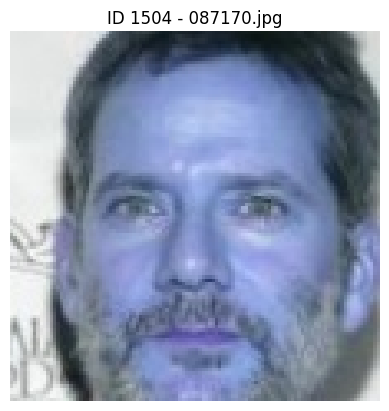

In [ ]:
# Kiem tra ket qua cuoi cung
import cv2, matplotlib.pyplot as plt, random, os

test_root = f"{DRIVE_OUTPUT}/CelebA_Aligned/train"

while True:
    p = random.choice(os.listdir(test_root))
    person_dir = f"{test_root}/{p}"

    files = [f for f in os.listdir(person_dir) if f.endswith(".jpg")]
    if len(files) == 0:
        continue  # chọn lại ID khác nếu không có ảnh

    img_file = random.choice(files)
    img_path = f"{person_dir}/{img_file}"

    img = cv2.imread(img_path)
    if img is None:
        continue  # file lỗi → thử file khác

    # thành công → hiển thị rồi break
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"ID {p} - {img_file}")
    break